In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import zipfile
import tensorflow as tf
from keras import utils

import keras
from keras.layers import Input, Add, Conv2D, LeakyReLU, Cropping2D, BatchNormalization, Concatenate, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import *
from keras.losses import *

In [2]:
# data_r = zipfile.ZipFile('..\\train.zip', 'r')
# data_r.extractall()

In [3]:
# data_r = zipfile.ZipFile('..\\test.zip', 'r')
# data_r.extractall()

In [4]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [5]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")

In [6]:
# задаём константы
IMG_WIDTH = 128                       # Ширина итогового изображения
IMG_LENGTH = 128                      # Длина итогового изображения
IMG_SHAPE  = (IMG_WIDTH, IMG_LENGTH)  # Формат изображения (ширина, длина)
CLASSES = 6 

In [7]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (IMG_WIDTH, IMG_LENGTH), method="nearest")
   input_mask = tf.image.resize(input_mask, (IMG_WIDTH, IMG_LENGTH), method="nearest")
   return input_image, input_mask

In [8]:
X_train, Y_train = resize(X_train, Y_train)
X_test, Y_test = resize(X_test, Y_test)

Объявление функций предобработки и пост обработки данных


In [9]:
# установка цвета полос
palette = {0 : (60, 16, 152), # Здания
           1 : (132, 41, 246), # Земля
           2 : (110, 193, 228), # Дороги
           3 : (254, 221, 58), # Растения
           4 : (226, 169, 41), # Вода
           5 : (155, 155, 155)} # Неразмечено

# обратное преобразование цвета в метку класса
invert_palette = {v: k for k, v in palette.items()}

# преобразование выхода нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Числовые метки для кодирования RGB-цвета """
    # zeros() возвращает новый массив указанной формы и типа, заполненный нулями.
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [10]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ Кодирование цвета RGB в полутоновый маркер """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    # принадлежность каждого пикселя классу
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8)

    # расстояние до ближайшего класса для пикселей
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 

    for c, i in palette.items():
      # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) 

      # поиск элементов меньше min_distance
      condition = min_distance > distance 

      # замена дистанции найденных элементов
      min_distance[condition] = distance[condition] 

      # замена класса найденных элементов
      arr_2d[condition] = i 

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

Предобработка исходных изображений и сегментированных изображений в ответ сети

In [11]:
# Следующий блок кода подготавливает данные для использования нейронной сетью
X_train_pred = np.array(X_train).reshape([7, IMG_WIDTH, IMG_LENGTH, 3])/255 
X_test_pred = np.array(X_test).reshape([2, IMG_WIDTH, IMG_LENGTH, 3])/255   
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)

In [12]:
X_train_pred.shape

(7, 128, 128, 3)

Объявление топологии нейронной сети

In [13]:
base_model = tf.keras.applications.vgg16.VGG16(input_shape=(IMG_WIDTH, IMG_LENGTH, 3), include_top=False)

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]
base_model.trainable = False
VGG_16 = tf.keras.models.Model(base_model.input, base_model_outputs)

In [14]:
def fcn8_decoder(convs, n_classes):
    #5 слоев после работы VGG16 
    f1, f2, f3, f4, p5 = convs
    n = 4096
    # две операции свертки с6 и с7
    c6 = Conv2D (
        n, (7, 7), activation='relu', padding='same', 
        name='conv6')(p5)
    c7 = Conv2D (
        n, (1, 1), activation='relu', padding='same', 
        name='conv7')(c6)

    # соединяем f5 и c7
    f5 = c7
    # транспонируем (операция обратная сверке)
    o = Conv2DTranspose(n_classes, kernel_size=(
        4, 4), strides=(2, 2), use_bias=False)(f5)
    # обрезка дополнительных пикселей
    o = Cropping2D(cropping=(1, 1))(o)

    # соединяем о2 с f4
    o2 = f4
    o2 = Conv2D (n_classes, (1, 1),
                                 activation='relu', padding='same')(o2)

    # добавляем информацию из слоя o2 в слой o
    o = Add()([o, o2])

    o = (Conv2DTranspose(n_classes, kernel_size=(
        4, 4), strides=(2, 2), use_bias=False)(o))
    o = Cropping2D(cropping=(1, 1))(o)

    o2 = f3
    o2 = Conv2D (n_classes, (1, 1),
                                 activation='relu', padding='same')(o2)
    o = Add()([o, o2])
    o = (Conv2DTranspose(n_classes, kernel_size=(
        8, 8), strides=(8, 8), use_bias=False)(o))
    o = tf.keras.layers.Activation('softmax')(o)

    return o

In [15]:
def segmentation_model():
    inputs = Input(shape=(IMG_WIDTH, IMG_LENGTH, 3))
    convs = VGG_16(inputs)
    outputs = fcn8_decoder(convs , CLASSES)
    model = Model(inputs=inputs, outputs=outputs)

    return model


model = segmentation_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
%%time
history = model.fit(X_train_pred, Y_train_pred, batch_size=1, epochs=100, 
                    validation_data=(X_test_pred, Y_test_pred))



Epoch 1/100
7/7 [==============================] - 16s 2s/step - loss: 2.1338 - accuracy: 0.1805 - val_loss: 1.9331 - val_accuracy: 0.1968
Epoch 2/100
7/7 [==============================] - 13s 2s/step - loss: 1.8343 - accuracy: 0.2094 - val_loss: 1.8179 - val_accuracy: 0.2132
Epoch 3/100
7/7 [==============================] - 13s 2s/step - loss: 1.7817 - accuracy: 0.2264 - val_loss: 1.7764 - val_accuracy: 0.2427
Epoch 4/100
7/7 [==============================] - 13s 2s/step - loss: 1.7432 - accuracy: 0.2608 - val_loss: 1.7524 - val_accuracy: 0.2828
Epoch 5/100
7/7 [==============================] - 17s 2s/step - loss: 1.6647 - accuracy: 0.3324 - val_loss: 1.6406 - val_accuracy: 0.3771
Epoch 6/100
7/7 [==============================] - 16s 2s/step - loss: 1.5241 - accuracy: 0.4284 - val_loss: 1.5318 - val_accuracy: 0.4728
Epoch 7/100
7/7 [==============================] - 15s 2s/step - loss: 1.3501 - accuracy: 0.5267 - val_loss: 1.5066 - val_accuracy: 0.5580
Epoch 8/100
7/7 [==========

In [17]:
# model.save('./save_model')

### Отрисовка точности модели (при обучении и на тестовых данных)

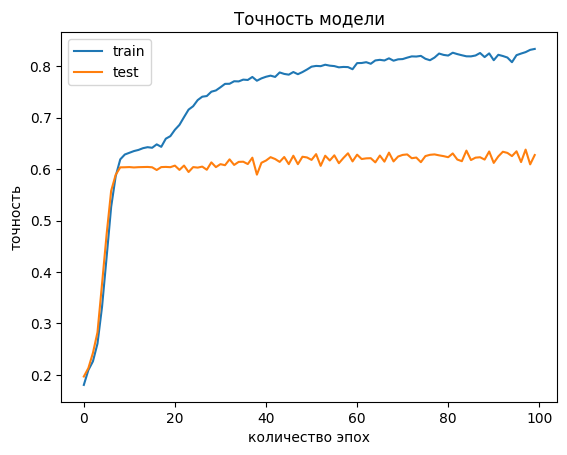

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Точность модели')
plt.ylabel('точность')
plt.xlabel('количество эпох')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# Делаем сегментацию для двух тестовых картинок
out = model.predict(X_test_pred[:2], batch_size=1)

2/2 [==============================] - 1s 163ms/step


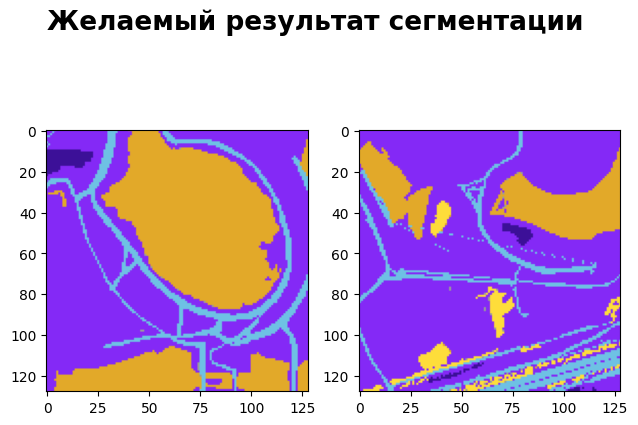

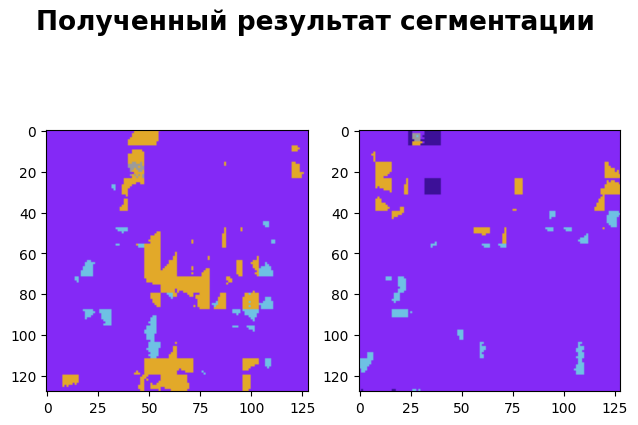

In [20]:
# Выведем 2-е тестовые картинки
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(Y_test_pred[i], axis=-1)))
plt.suptitle('Желаемый результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

# Выведем 2-е картинки полученые методом predict
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(out[i], axis=-1)))
plt.suptitle('Полученный результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

Вывод: Данное исследование было проведено с помощью модели НС из семинара. В качестве энкодинга использовалась готовая модель VGG16. На обучающих данных был показан результат чуть выше 83%, на тестовых модель застопорилась на 60% (с чем это связано не пойму). Полученный результат сегментации мало похож на ожидаемый